# 📝 Handwritten Digits Classification

- 🔢 **Task:** Classifying handwritten digits (0-9) from images.
- 🧠 **Model:** Convolutional Neural Network (CNN) with Data Augmentation.
- 📈 **Evaluation:** Accuracy, Loss, Confusion Matrix.  
- 🚀 **Tools:** TensorFlow/Keras.  
- 🧑‍💻 **Skill Level:** Intermediate Data Scientist.  
- 🎯 **Goal:** Develop an accurate and robust model that can recognize handwritten digits efficiently.

Let’s jump into it and start building our models! 🚀

# Setup and Load Data 📂

## Import Libraries 📚

In [ ]:
# Create a new environment and set it as the active kernel in this Jupyter Notebook.
# !pip install numpy pandas seaborn matplotlib tensorflow keras-tuner

In [4]:
import zipfile
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import cv2
import requests
from PIL import Image
from io import BytesIO

## Setup 🛠

The dataset is small, and both ANN and CNN models can train quickly on a CPU. However, if you have a GPU, training will be faster, especially for CNN. 🚀

In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
# Avoid OOM (Out Of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Load data 📥

💡Download the dataset from Kaggle https://www.kaggle.com/competitions/digit-recognizer/data

In [7]:
# Define the dataset path
dataset_path = "dataset"

# Create the dataset directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Unzip train.csv.zip and test.csv.zip into the dataset folder
with zipfile.ZipFile("train.csv.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_path)

with zipfile.ZipFile("test.csv.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_path)

# Read CSV File
train = pd.read_csv(os.path.join(dataset_path, "train.csv"))

In [8]:
print(type(train))
train.head()

<class 'pandas.core.frame.DataFrame'>


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Extract Features and Label 🗂️

In [9]:
# From train dataset
y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1)

# EDA 🔍

## Class Distribution 📊

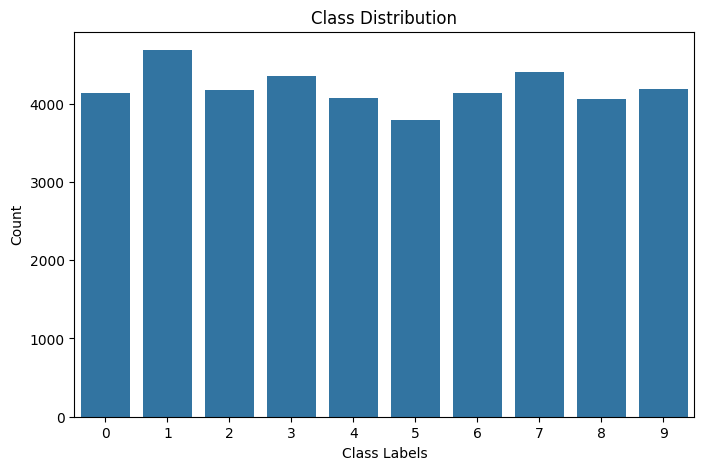

In [10]:
# Count class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

We have similar counts for the 10 digits.

## Number of images 🖼️ 

In [11]:
len(train)

42000

## Preview same samples 👁️

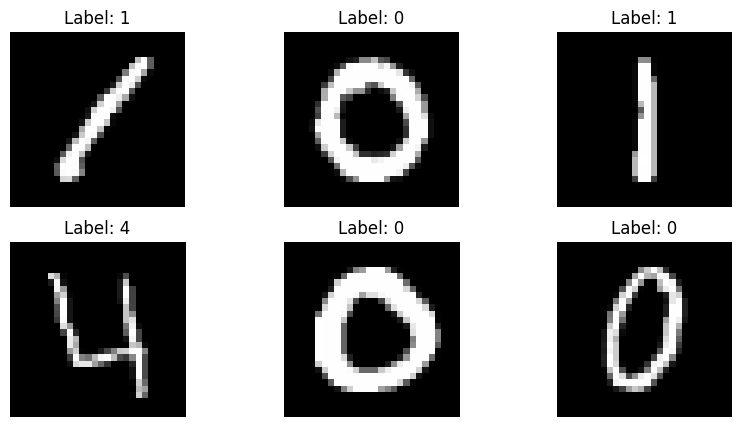

In [12]:
plt.figure(figsize=(10, 5))

for i in range(6):  # Display only 6 images
    plt.subplot(2, 3, i+1)  # 2 rows, 3 columns
    plt.imshow(X_train.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train.iloc[i]}")
    plt.axis('off')

plt.show()

##  Check for Null and Missing Values 🔍

In [13]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

- count = 784: There are 784 columns (pixels in the 28x28 images).
- unique = 1: There is only one unique value (either True or False).
- top = False: The most common value is False, meaning no missing values were found.
- freq = 784: All 784 columns have False, confirming that no missing values exist.

Conclusion: There are no missing values in X_train or test. So we can safely go ahead.

# Preprocess Data 📦

## Normalization 📏

In [14]:
X_train = X_train / 255.0

## Reshape To Match The Keras's Expectations 🔄

In [15]:
print(type(X_train)) 
print(X_train.shape) 

<class 'pandas.core.frame.DataFrame'>
(42000, 784)


In [16]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1, 28, 28, 1)

In [17]:
print(type(X_train)) 
print(X_train.shape) 

<class 'numpy.ndarray'>
(42000, 28, 28, 1)


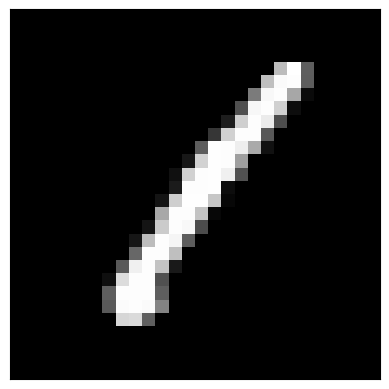

In [18]:
# Display the first image
plt.imshow(X_train[0].squeeze(), cmap='gray')  # Remove the extra channel
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

## Split Data ✂️

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
X_train.shape, X_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1))

A small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

## Data Augmentation 🎨

In [20]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # Randomly rotate images
    zoom_range=0.1,     # Randomly zoom image
    width_shift_range=0.1,  # Randomly shift images horizontally
    height_shift_range=0.1,  # Randomly shift images vertically
    horizontal_flip=False,   # Randomly flip images
    vertical_flip=False      # Randomly flip images
)

# Fit the generator to the training data
datagen.fit(X_train)

Let's jump into **training our neural network** and see how it performs! 🧠🔥

# Convolutional Neural Network (CNN) 🧠

## Train the Model 🏋️‍♂️

In [30]:
# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu', input_shape=(28, 28, 1)),
    Conv2D(filters=32, kernel_size=(5, 5), padding='Same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Dropout(0.25),

    # Flatten and dense layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer
    Dense(10, activation='softmax')
])

# Compile the model
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [32]:
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, # Without Augmentation : val_accuracy = 98%
#                     validation_data=(X_val, y_val), 
#                     callbacks=[early_stop, learning_rate_reduction])

In [31]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),  # Use the ImageDataGenerator to augment data
                    epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, learning_rate_reduction])

Epoch 1/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.7623 - loss: 0.7187 - val_accuracy: 0.9807 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 2/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.9588 - loss: 0.1451 - val_accuracy: 0.9883 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 3/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.9681 - loss: 0.1066 - val_accuracy: 0.9895 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 4/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 56s 48ms/step - accuracy: 0.9737 - loss: 0.0925 - val_accuracy: 0.9881 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 5/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.9755 - loss: 0.0852 - val_accuracy: 0.9888 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 6/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.9760 - loss: 0.0836 - val_accuracy: 0.9907 - val_loss: 0.0395 - learning_rate: 0.0010
Epoch 7/50
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accura

## Evaluate the Model 🔬

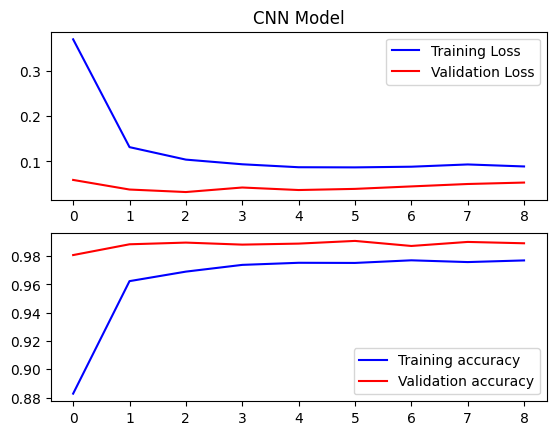

In [33]:
# plot training history
fix, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label='Training Loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation Loss')
ax[0].set_title("CNN Model")
ax[0].legend()

ax[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax[1].legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


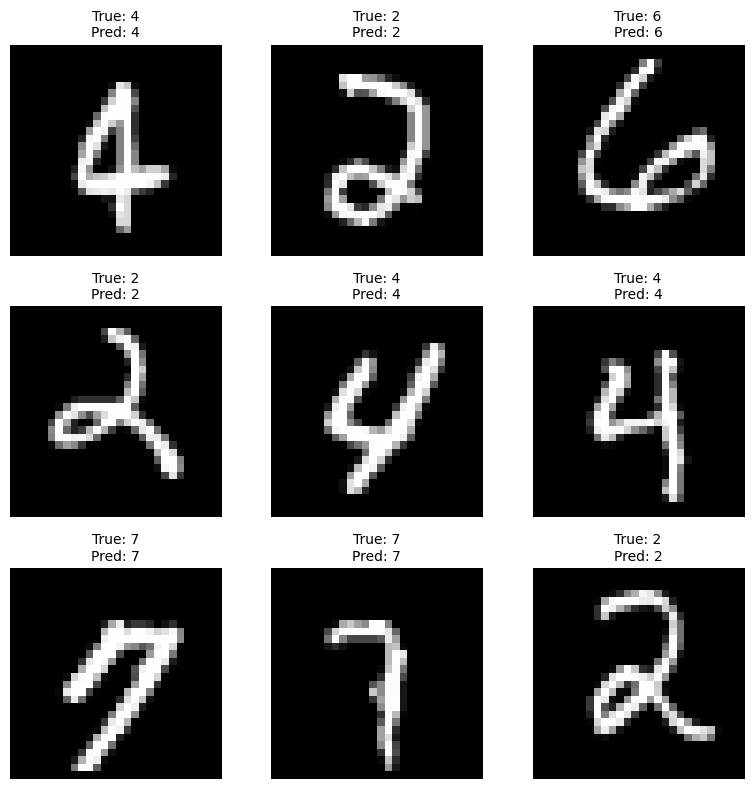

In [34]:
# Define the number of images to display
num_images = 9

# Select random indices from X_test
indices = np.random.choice(len(X_val), num_images, replace=False)
images = X_val[indices]
y_val = np.array(y_val)
true_labels = y_val[indices]

# Expand dimensions and predict
predictions = [np.argmax(model.predict(np.expand_dims(img, axis=0))) for img in images]

# Plot images with actual and predicted labels
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap="gray")
    ax.set_title(f"True: {true_labels[i]}\nPred: {predictions[i]}", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Confusion Matrix  🟠

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


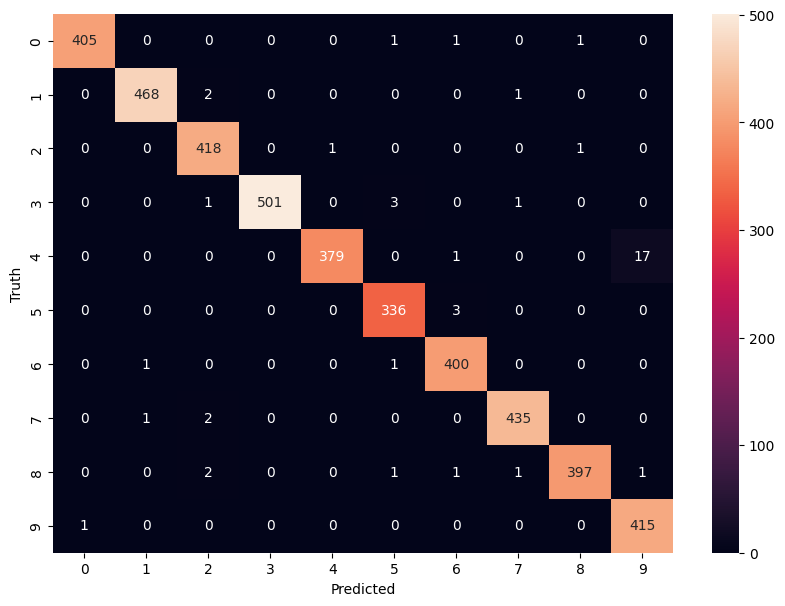

In [35]:
y_pred = model.predict(X_val)
y_pred_labels = [np.argmax(i) for i in y_pred]
cm = tf.math.confusion_matrix(labels=y_val, predictions=y_pred_labels)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

Our CNN performs exceptionally well on all digits, with only a few errors given the validation set size of 4,200 images.  

However, the model struggles slightly with the digit **4**, often misclassifying it as **9**. This is understandable, as distinguishing between 4 and 9 can be challenging, especially when the curves are smooth.

# Run Inference ⚡

## Save and Load Model 📥

In [36]:
model.save("digit_recognizer_model.keras")
digit_recognizer_model= load_model('digit_recognizer_model.keras')

## Predict Labels for test.csv 📤

In [44]:
# Read the test dataset
test = pd.read_csv(os.path.join(dataset_path, "test.csv"))

# Get the length of the train dataset
print(len(train)
     )
# Check if there are any missing values in the test dataset and describe the result
test.isnull().any().describe()

42000


count       784
unique        1
top       False
freq        784
dtype: object

In [45]:
# Ensure test data is properly shaped and normalized
test = test.values.reshape(-1, 28, 28, 1) / 255.0  # Normalize like X_train

# Predict labels
predictions = digit_recognizer_model.predict(test)

# Convert predictions to label indices (0-9)
predicted_labels = np.argmax(predictions, axis=1)

# Create submission DataFrame
submission = pd.DataFrame({"ImageId": np.arange(1, len(predicted_labels) + 1), 
                           "Label": predicted_labels})

# Save to CSV
submission.to_csv("submission_v1.csv", index=False)

print("Submission file saved as submission.csv")

875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Submission file saved as submission.csv


Submit your file on https://www.kaggle.com/competitions/digit-recognizer/submissions to see the score!

# Digit Recognition Classifier | Made with 🩷 